In [108]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline

In [ ]:
# 目标是使用深度学习注意力网络,构建具有可解释性的用于表格数据的模型(速度较慢)
# 在保留DNN的end-to-end和representation learning特点的基础上,还拥有了树模型的可解释性和稀疏特征选择的优

### 数据处理

In [109]:
train = pd.read_csv('data/census-income.csv')
train

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [110]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1],
                                    size=(train.shape[0],))  # 训练数据集,验证数据集,测试数据集比例

train_indices = train[train.loc[:, "Set"] == "train"].index  # 训练数据集索引
valid_indices = train[train.loc[:, "Set"] == "valid"].index  # 验证数据集索引
test_indices = train[train.loc[:, "Set"] == "test"].index  # 测试数据集索引

In [111]:
nunique = train.nunique()
nunique

39                   73
 State-gov            9
 77516            21647
 Bachelors           16
 13                  16
 Never-married        7
 Adm-clerical        15
 Not-in-family        6
 White                5
 Male                 2
 2174               119
 0                   92
 40                  94
 United-States       42
 <=50K                2
Set                   3
dtype: int64

In [112]:
types = train.dtypes
types

39                 int64
 State-gov        object
 77516             int64
 Bachelors        object
 13                int64
 Never-married    object
 Adm-clerical     object
 Not-in-family    object
 White            object
 Male             object
 2174              int64
 0                 int64
 40                int64
 United-States    object
 <=50K            object
Set               object
dtype: object

In [113]:
categorical_columns = []  # 分类特征
categorical_dims = {}  # 分类特征和该特征唯一值数量
for col in train.columns:
    # 分类特征处理
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()  # 标签二值化===================>改注意的地方
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        # 非分类特征缺失值处理
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

print(categorical_columns)
print(categorical_dims)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3
['39', ' State-gov', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States', ' <=50K', 'Set']
{'39': 73, ' State-gov': 9, ' Bachelors': 16, ' 13': 16, ' Never-married': 7, ' Adm-clerical': 15, ' Not-in-family': 6, ' White': 5, ' Male': 2, ' 2174': 119, ' 0': 92, ' 40': 94, ' United-States': 42, ' <=50K': 2, 'Set': 3}


In [114]:
# 标签处理
target = ' <=50K'
train.loc[train[target] == 0, target] = "wealthy"
train.loc[train[target] == 1, target] = "not_wealthy"

In [115]:
unused_feat = ['Set']

# 特征
features = [col for col in train.columns if col not in unused_feat + [target]]

# 分类特征id
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

# 每个分类特征唯一值数量
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

print(features)
print(cat_idxs)
print(cat_dims)

['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States']
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]


In [116]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [117]:
# X_trainl.shape = (n_sample, n_feature)
print(X_train.shape)
# y_train.shape = (n_sample, )
print(y_train.shape)

(26127, 14)
(26127,)


### TabNetClassifier二分类模型

In [118]:
clf = TabNetClassifier(
    # Width of the decision prediction layer.
    # Bigger values gives more capacity to the model with the risk of overfitting.
    # Values typically range from 8 to 64.
    n_d=8,  # 默认n_d=8
    # Width of the attention embedding for each mask.
    # According to the paper n_d=n_a is usually a good choice. (default=8)
    n_a=8,  # 默认n_a=3
    # Number of steps in the architecture (usually between 3 and 10)
    n_steps=3,  # 默认n_steps=3
    # This is the coefficient for feature reusage in the masks.
    # A value close to 1 will make mask selection least correlated between layers.
    # Values range from 1.0 to 2.0.
    gamma=1.3,  # 默认gamam=1.3
    # Number of shared Gated Linear Units at each step Usual values range from 1 to 5
    n_shared=2,  # 默认n_shared=2
    # This is the extra sparsity loss coefficient as proposed in the original paper.
    # The bigger this coefficient is, the sparser your model will be in terms of feature selection.
    # Depending on the difficulty of your problem, reducing this value could help.
    lambda_sparse=1e-3,  #  默认lambda_sparse=1e-3
    # 分类特征索引列表;默认值[]
    cat_idxs=cat_idxs,
    # 每个分类特征唯一值数量;默认值[]
    cat_dims=cat_dims,
    # pytorch优化器;默认torch.optim.Adam
    optimizer_fn=torch.optim.Adam,
    # pytorch优化器参数
    optimizer_params=dict(lr=2e-2),
    # pytorch学习率调整
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    # pytorch学习率调整对于参数
    scheduler_params={"step_size": 50,  # how to use learning rate scheduler
                      "gamma": 0.9},
    # this is the masking function to use for selecting features.
    # (default='sparsemax') Either "sparsemax" or "entmax"
    mask_type='entmax',
    # clip_value : float (default None)
    # If a float is given this will clip the gradient at clip_value.
    clip_value=2.0,
    seed=1,
    device_name='auto',  # 默认device_name='auto',可选参数'auto'/'cuda'/'cpu'
    # Verbosity for notebooks plots, set to 1 to see every epoch, 0 to get None.
    verbose=10  # 默认verbose=1
)
clf

Device used : cuda


TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=1, clip_value=2.0, verbose=10, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=None, output_dim=None, device_name='auto')

In [119]:
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.metrics import Metric


class Gini(Metric):
    """自定义评价指标"""

    def __init__(self):
        self._name = "gini"  # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        auc = roc_auc_score(y_true, y_score[:, 1])
        return max(2 * auc - 1, 0.)


def my_loss_fn(y_pred, y_true):
    """自定义损失函数"""
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1 - y_true) * torch.log(softmax_pred[:, 0])
    logloss += y_true * torch.log(softmax_pred[:, 1])
    return -torch.mean(logloss)

In [120]:
clf.fit(
    X_train=X_train,
    y_train=y_train,
    # List of eval tuple set (X, y).
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # List of eval set names.
    eval_name=['train', 'valid'],
    # List of evaluation metrics.
    # The last metric is used for early stopping.
    # binary classification metrics : 'auc', 'accuracy', 'balanced_accuracy', 'logloss'
    # multiclass classification : 'accuracy', 'balanced_accuracy', 'logloss'
    # regression: 'mse', 'mae', 'rmse', 'rmsle'
    eval_metric=['auc', Gini],
    # loss function for training (default to mse for regression and cross entropy for classification)
    loss_fn=F.cross_entropy,  # 使用pytorch其他损失函数
    # Maximum number of epochs for trainng.
    max_epochs=300,  # 默认值200
    # Number of consecutive epochs without improvement before performing early stopping.
    patience=20,  # 默认值15
    # Number of examples per batch. Large batch sizes are recommended.
    batch_size=1024,  # 默认值1024
    # Number or workers used in torch.utils.data.Dataloader
    # num_workers=8,  # 默认值0

    # Size of the mini batches used for "Ghost Batch Normalization". /!\ virtual_batch_size should divide batch_size
    virtual_batch_size=128,  # 默认值128
    # Only for TabNetClassifier Sampling parameter 0 : no sampling 1 : automated sampling with inverse class occurrences dict : keys are classes, values are weights for each class
    weights=1,
    # Whether to drop last batch if not complete during training
    drop_last=False  # 默认值false
)

epoch 0  | loss: 0.63765 | train_auc: 0.66863 | train_gini: 0.33726 | valid_auc: 0.66149 | valid_gini: 0.32299 |  0:00:01s
epoch 10 | loss: 0.37459 | train_auc: 0.91158 | train_gini: 0.82317 | valid_auc: 0.90322 | valid_gini: 0.80644 |  0:00:17s
epoch 20 | loss: 0.34013 | train_auc: 0.92872 | train_gini: 0.85743 | valid_auc: 0.91634 | valid_gini: 0.83267 |  0:00:34s
epoch 30 | loss: 0.33663 | train_auc: 0.93372 | train_gini: 0.86743 | valid_auc: 0.92025 | valid_gini: 0.8405  |  0:00:50s
epoch 40 | loss: 0.32347 | train_auc: 0.93502 | train_gini: 0.87003 | valid_auc: 0.91829 | valid_gini: 0.83657 |  0:01:07s

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_gini = 0.84498
Best weights from best epoch are automatically used!


### 结果分析

In [121]:
# pytorch_tabnet.callbacks.History类型
clf.history

{'loss': [0.6376486898230536, 0.5016352500393374, 0.47060597353543326, 0.44656051698711813, 0.42354506964948535, 0.41805221506597234, 0.41238681935810506, 0.3953883422887042, 0.39455902971118845, 0.37982634508377533, 0.37458614896709574, 0.37117438141799675, 0.3626360043700246, 0.36298365374768915, 0.3554611056638137, 0.3466781338165434, 0.35195640298010455, 0.335785567474159, 0.3394685064128379, 0.33643677264809013, 0.34012819748523976, 0.33799118727517463, 0.34193762831277835, 0.3370551797896241, 0.34333598953430966, 0.3329950917824295, 0.33248439234652805, 0.3337226982377137, 0.3369413561551238, 0.33173657702962556, 0.3366295664780503, 0.32943585022480354, 0.3231361167320096, 0.32729213073026686, 0.3396535288825823, 0.32562126673202807, 0.3284732174445829, 0.33352053893070094, 0.3309241498671448, 0.3215653549214065, 0.3234655786079385, 0.32041209786371816, 0.31973238234432905, 0.3194983880806495, 0.3165056009209014, 0.3175019878283403, 0.315616569345159, 0.3279191641104993, 0.323809

In [122]:
# 字典类型
clf.history.history

{'loss': [0.6376486898230536,
  0.5016352500393374,
  0.47060597353543326,
  0.44656051698711813,
  0.42354506964948535,
  0.41805221506597234,
  0.41238681935810506,
  0.3953883422887042,
  0.39455902971118845,
  0.37982634508377533,
  0.37458614896709574,
  0.37117438141799675,
  0.3626360043700246,
  0.36298365374768915,
  0.3554611056638137,
  0.3466781338165434,
  0.35195640298010455,
  0.335785567474159,
  0.3394685064128379,
  0.33643677264809013,
  0.34012819748523976,
  0.33799118727517463,
  0.34193762831277835,
  0.3370551797896241,
  0.34333598953430966,
  0.3329950917824295,
  0.33248439234652805,
  0.3337226982377137,
  0.3369413561551238,
  0.33173657702962556,
  0.3366295664780503,
  0.32943585022480354,
  0.3231361167320096,
  0.32729213073026686,
  0.3396535288825823,
  0.32562126673202807,
  0.3284732174445829,
  0.33352053893070094,
  0.3309241498671448,
  0.3215653549214065,
  0.3234655786079385,
  0.32041209786371816,
  0.31973238234432905,
  0.3194983880806495,
 

In [123]:
# 通过设置eval_set,eval_metric参数生成评估指标(train_auc,train_gini,valid_auc,valid_gini)
clf.history.history.keys()

dict_keys(['loss', 'lr', 'train_auc', 'train_gini', 'valid_auc', 'valid_gini'])

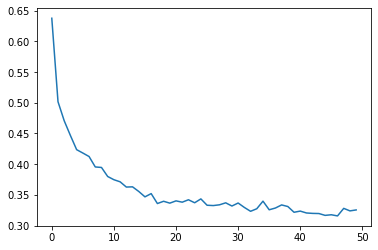

In [124]:
# plot losses(训练数据集)
plt.plot(clf.history['loss'])

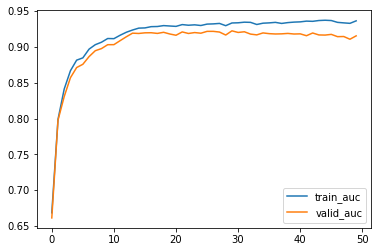

In [125]:
# plot auc
plt.plot(clf.history['train_auc'], label="train_auc")
plt.plot(clf.history['valid_auc'], label="valid_auc")
plt.legend()

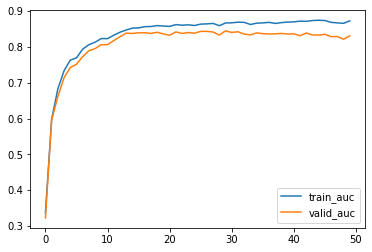

In [126]:
# plot gini
plt.plot(clf.history['train_gini'], label="train_auc")
plt.plot(clf.history['valid_gini'], label="valid_auc")
plt.legend()

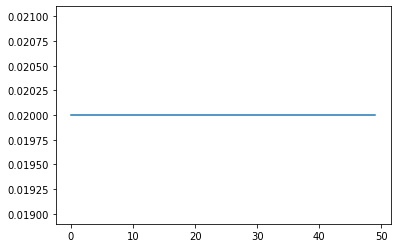

In [127]:
# plot learning rates
plt.plot(clf.history['lr'])

In [137]:
# 数据类别
clf.classes_

array(['not_wealthy', 'wealthy'], dtype='<U11')

In [138]:
clf.predict(X_test)  # (n_sample, )

array(['wealthy', 'wealthy', 'wealthy', ..., 'not_wealthy', 'wealthy',
       'not_wealthy'], dtype='<U11')

In [139]:
clf.predict_proba(X_test)  # (n_sample, num_class)

array([[4.3318802e-03, 9.9566805e-01],
       [2.7385766e-02, 9.7261423e-01],
       [1.9486868e-03, 9.9805129e-01],
       ...,
       [9.9967849e-01, 3.2147451e-04],
       [2.2091286e-03, 9.9779081e-01],
       [7.8999048e-01, 2.1000953e-01]], dtype=float32)

In [141]:
# 特征的相对重要性
clf.feature_importances_

array([5.28605475e-02, 6.02396464e-03, 1.10621756e-03, 5.71976419e-02,
       6.11038782e-02, 5.57130073e-02, 8.98064820e-02, 1.76017477e-01,
       4.20441088e-03, 4.83205460e-02, 2.14003395e-01, 1.34963887e-01,
       9.86335529e-02, 4.49929194e-05])

### 保存和加载模型

In [142]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [143]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model('tabnet_model_test_1.zip')

Device used : cuda
Device used : cuda


In [151]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:, 1], y_true=y_test)

print(f"FINAL TEST SCORE FOR census-income : {loaded_test_auc}")
print(loaded_clf.predict(X_test))

FINAL TEST SCORE FOR census-income : 0.9183328952844032
['wealthy' 'wealthy' 'wealthy' ... 'not_wealthy' 'wealthy' 'not_wealthy']
